## in this notebook i build 2 catboost classifiers for different sets of features: including (1) only morphometrical parametes and (2) morphometrical + climatic parameters 



In [1]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)

import catboost
from catboost import *
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import get_roc_curve, get_confusion_matrix

import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

# other things: 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score

import shap 

!jupyter nbextension enable --py widgetsnbextension



Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### all features here: morphometrical and climate  

In [2]:
# in this notebook varya is trying to buld a "best-working" catboost classifier for the DF and FF catchments 
# then "deconstrust" that model for the shap values to see how different features affect the result of the model 
# PD? 


# 1. read data and lable cat features 
# 2. split to train and test 
# 3. find the right hyperparameters (grid search)
# 4. choose the "best model" - save the parameters 
# 5. 



# https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83

### 1. read the data, defince X and y, defince categorical features for y 

In [3]:
# read the data: 

path = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/ml_model/data_current/'
df = pd.read_csv(path + '09082022dfclim_permafrost.csv', sep = ',', index_col = 0)

df = df[df.target.isin([1,0])]
df = df.drop(['DN', 'Name', 'mean_daylymonsoon_tp_x', 'region_name'], axis = 1)


In [4]:
y = df.target
X = df.drop(columns=['target'])


# # what values are categorical: 
# # region, glacier, avgtemp_belowzero, cont_permafrost, any_permafrost, cont_permafrost_frac50
X['glacier'] = X['glacier'].astype('category') # n 21
X['region'] = X['region'].astype('category') # n 12
X['avgtemp_belowzero'] = X['avgtemp_belowzero'].astype('category') # n 34
X['cont_permafrost'] = X['cont_permafrost'].astype('category') # n 51
X['any_permafrost'] = X['any_permafrost'].astype('category') # n 52
X['cont_permafrost_frac50'] = X['cont_permafrost_frac50'].astype('category') # n 54

# cat_features = list([12, 21, 34, 50, 51, 53])
cat_features = list(['glacier', 'region', 'avgtemp_belowzero', 'cont_permafrost', 'any_permafrost', 'cont_permafrost_frac50'])

In [5]:
# X.dtypes
# Just change the categorical variables to the string by .astype(str)
# and when you check the data types by using .dtypes you will see them as "objects"
# then pass the cat_features as a list of indices. That would work fine.

# Don't change the data type to the category by .astype('category')


X['glacier'] = X['glacier'].astype(str) # n 21
X['region'] = X['region'].astype(str) # n 12
X['avgtemp_belowzero'] = X['avgtemp_belowzero'].astype(str) # n 34
X['cont_permafrost'] = X['cont_permafrost'].astype(str) # n 51
X['any_permafrost'] = X['any_permafrost'].astype(str) # n 52
X['cont_permafrost_frac50'] = X['cont_permafrost_frac50'].astype(str) # n 54

cat_features = list([12, 21, 34, 50, 51, 53])
# cat_features = list(['glacier', 'region', 'avgtemp_belowzero', 'cont_permafrost', 'any_permafrost', 'cont_permafrost_frac50'])

In [6]:
# data split:

df['target'].value_counts()

1    539
0    173
Name: target, dtype: int64

In [7]:
539 + 173

712

In [8]:
# random guess: 
    
print('random guess chanses with this data split: %.2f%%' % (539/712 * 100)) #df/total 

random guess chanses with this data split: 75.70%


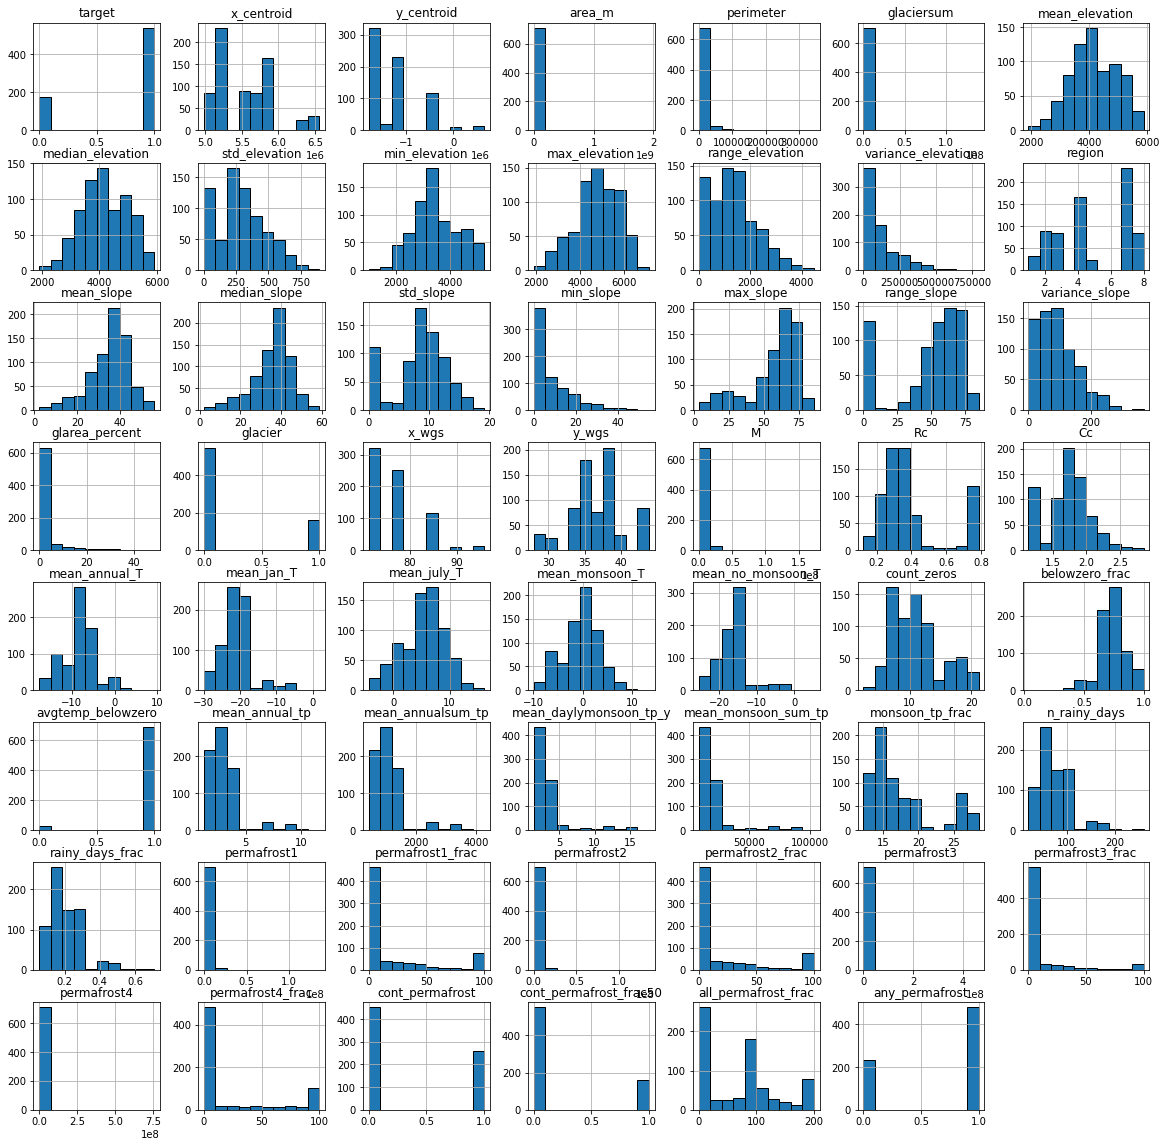

In [9]:
df.hist(edgecolor = "black" , figsize = (20 , 20));


### 2. classifier data prep: split to train and test, convert to pool data class 

In [10]:
# train test 

seed = 42
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


In [11]:
# X_train.dtypes

In [12]:
# pool

train_pool = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features,
                 )

test_pool = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features,
                 )

data_pool = Pool(X, y, cat_features = cat_features)

### 3. catboost classifier - build the model and identify the hyperparameters that are needed 

In [13]:
# default parameters:

params = {
    'loss_function': 'CrossEntropy',
    'iterations': 1000,
    'learning_rate': 0.03,
    'custom_metric' : ['Logloss', 'Accuracy', 'AUC:hints=skip_train~false'],
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}

### simple model (default-ish) - nice but we dont really care 

In [14]:

# # ------ model ------
# model = CatBoostClassifier(**params)
# model.fit(train_pool, 
#           eval_set=test_pool, 
#           plot = True)

# print('simple model validation Accuracy: {:.4}'.format(
#     accuracy_score(y_test, model.predict(X_test))
# ))


# print('best model get best iteration: \n', model.get_best_iteration())

# print('\n simple model get best score: \n', model.get_best_score())



In [15]:
# (fpr, tpr, thresholds) = get_roc_curve(model, train_pool, plot=True)
# print(fpr)
# print(tpr)
# print(thresholds)

In [16]:
# get_confusion_matrix(model, data_pool)

In [17]:

# ------ best model ------

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})

best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, 
               eval_set=test_pool, 
               plot = True)



print('Best model validation Accuracy: {:.4}'.format(
    accuracy_score(y_test, best_model.predict(X_test))
))

print('')
print('parameters for the "best model: \n', best_model.get_params())

print(' ')
print('best model get best iteration: \n', best_model.get_best_iteration())

print(' ')
print('best model get best score: \n', best_model.get_best_score())



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best model validation Accuracy: 0.8925

parameters for the "best model: 
 {'iterations': 1000, 'learning_rate': 0.03, 'loss_function': 'CrossEntropy', 'random_seed': 42, 'use_best_model': True, 'logging_level': 'Silent', 'custom_metric': ['Logloss', 'Accuracy', 'AUC:hints=skip_train~false']}
 
best model get best iteration: 
 121
 
best model get best score: 
 {'learn': {'Accuracy': 1.0, 'Logloss': 0.011252582369533921, 'CrossEntropy': 0.011252582369533921, 'AUC': 1.0}, 'validation': {'Accuracy': 0.9112149532710281, 'Logloss': 0.29971753525515543, 'CrossEntropy': 0.29971753525515543, 'AUC': 0.9162757127390834}}


Cannot restore border parameter, falling to default border = 0.5


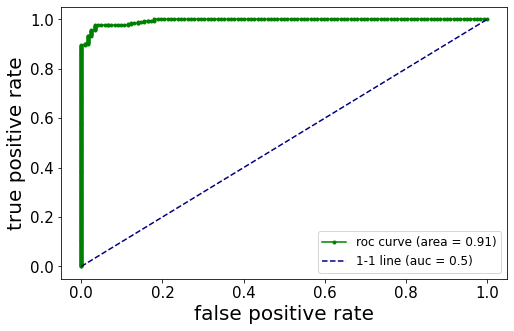

In [18]:

fpr, tpr, thresholds = get_roc_curve(best_model, train_pool, plot=False)

roc = roc_auc_score(y_test, best_model.predict_proba(X_test)[: , 1])

# print(thresholds)
## calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# auc = roc_auc_score(y_test, probs)


fig, ax = plt.subplots(figsize = (8,5))
plt.plot(fpr, tpr, color = 'green', marker='.', label = 'roc curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label = '1-1 line (auc = 0.5)')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('false positive rate', fontsize=20)
plt.ylabel('true positive rate',fontsize=20)
plt.legend(fontsize=12)

# plt.savefig('figs_talk/roc_climate.pdf')

In [19]:
print('catboost best model Area Under ROC curve:', round(roc, 3))
get_confusion_matrix(best_model, data_pool)

# fpr, tpr, thresholds = get_roc_curve(best_model, train_pool, plot=True)


catboost best model Area Under ROC curve: 0.908


array([[145.,  28.],
       [ 17., 522.]])

### model done - next - predictions 

In [20]:
probs = best_model.predict_proba(X)


## predictions done! next: what does that mean 

In [21]:
feature_import = best_model.get_feature_importance(prettified=True)
feature_import.head()

,Feature Id,Importances
0,area_m,12.853109
1,M,10.876643
2,mean_slope,6.450088
3,median_slope,6.048886
4,perimeter,5.540267


Text(0.5, 1.0, 'CatBoost features importance:')

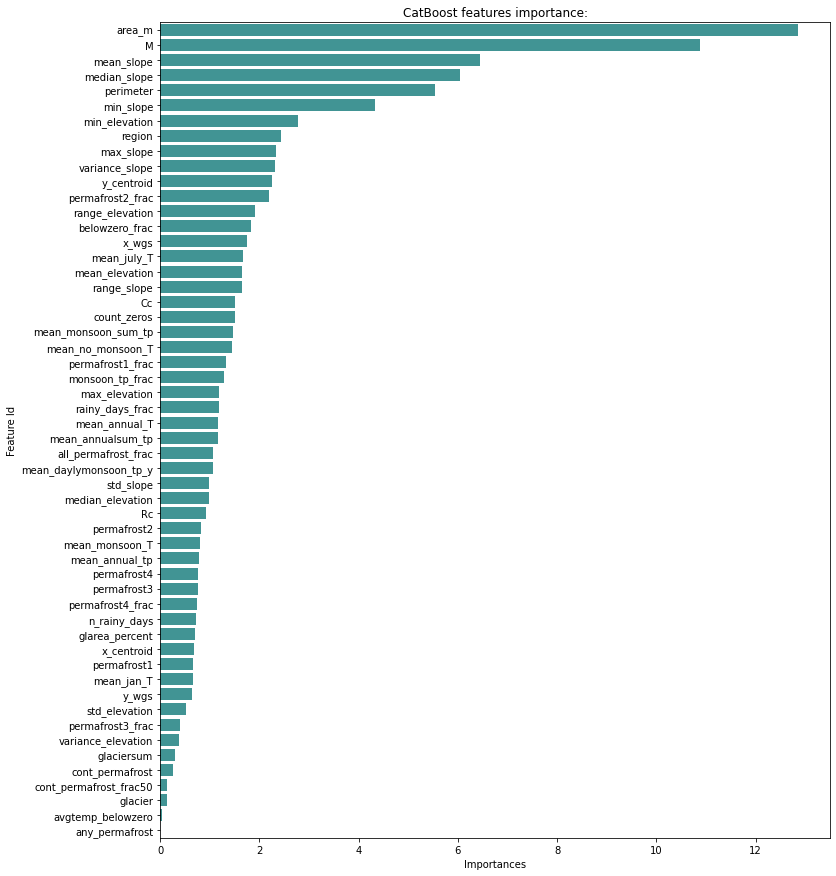

In [22]:
plt.figure(figsize=(12, 15))
sns.barplot(x="Importances", y="Feature Id", data=feature_import, color='darkcyan', alpha = 0.8)
plt.title('CatBoost features importance:')

In [23]:
shap_values_X   = best_model.get_feature_importance(data_pool, type='ShapValues')
shap_values_test = best_model.get_feature_importance(test_pool, type='ShapValues')

shap_values_test = shap_values_test[:,:-1]

In [24]:
explainer = shap.TreeExplainer(best_model)

# shap_valuesX = explainer.shap_values(X)
# shap.summary_plot(shap_valuesX, X)

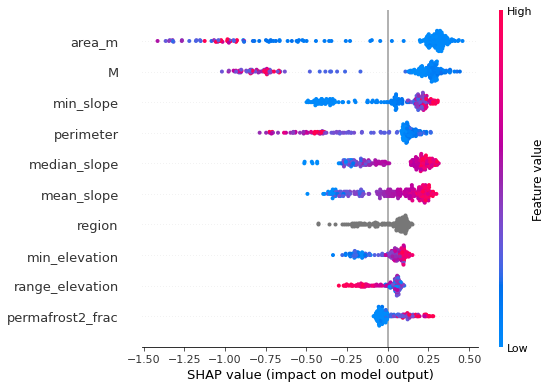

In [25]:
shap_valuesTE = explainer.shap_values(X_test)
shap.summary_plot(shap_valuesTE, X_test, max_display=10, show=False)

# plt.savefig('figs_talk/climate_shap_testdata_first10.pdf')

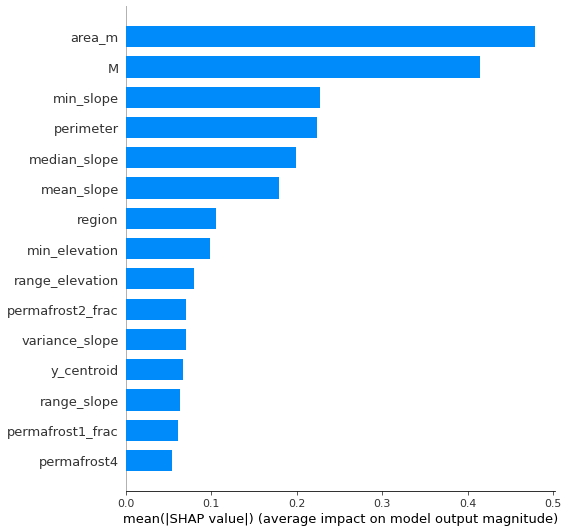

In [26]:
shap.summary_plot(shap_valuesTE, X_test, max_display=15, plot_type="bar")



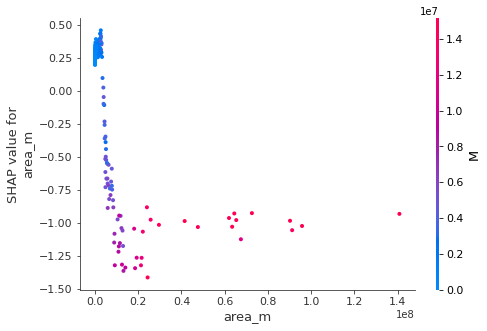

In [27]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('area_m', shap_values_test, X_test)

## partial dependence stuff 

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


(0.0, 1.0)

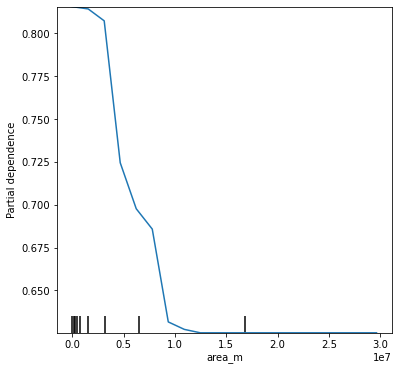

In [44]:

from sklearn.inspection import partial_dependence, plot_partial_dependence

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_ylim(0, 1)
my_plots = plot_partial_dependence(best_model,       
                                   features=['area_m'],       # column numbers of plots we want to show
                                   X=X,                        # raw predictors data.
                                   grid_resolution=20,
                                   response_method='predict_proba', 
                                   ax=ax)  # number of values to plot on x axis
ax.set_ylim(0, 1)

# plt.savefig('figs_talk/PD_area_example_fortalk2.pdf')

A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.


In [42]:
pddata

AttributeError: 'tuple' object has no attribute 'plot'

In [28]:
type(a)

NameError: name 'a' is not defined

In [ ]:
a = ['x_centroid', 'y_centroid', 'area_m', 'perimeter', 
        'mean_elevation', 'median_elevation', 'std_elevation',
        'min_elevation', 'max_elevation', 'range_elevation',
        'variance_elevation', 'region', 'mean_slope', 'median_slope',
        'std_slope', 'min_slope', 'max_slope', 'range_slope', 'variance_slope',
        'M', 'Rc', 'Cc']

# !!! only morphometry 

In [25]:
# df.columns
df2 = df.copy()
y2 = df2.target

X2 = df2[df2.columns[df2.columns.isin(['x_centroid', 'y_centroid', 'area_m', 'perimeter', 
        'mean_elevation', 'median_elevation', 'std_elevation',
        'min_elevation', 'max_elevation', 'range_elevation',
        'variance_elevation', 'region', 'mean_slope', 'median_slope',
        'std_slope', 'min_slope', 'max_slope', 'range_slope', 'variance_slope',
        'M', 'Rc', 'Cc'])]]

# X = df2[['x_centroid', 'y_centroid', 'area_m', 'perimeter', 
#         'mean_elevation', 'median_elevation', 'std_elevation',
#         'min_elevation', 'max_elevation', 'range_elevation',
#         'variance_elevation', 'region', 'mean_slope', 'median_slope',
#         'std_slope', 'min_slope', 'max_slope', 'range_slope', 'variance_slope',
#         'M', 'Rc', 'Cc']]

# X['region'] = X['region'].astype('str') # n 12

# cat_features = list([12])

In [26]:
X2['region'] = X2['region'].astype('str') # n 12
cat_features2 = list([11])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
# X2.dtypes

In [28]:


test_size = 0.3
seed = 42

# train test 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=test_size, random_state=seed)

# pool

train_pool2 = Pool(data=X_train2,
                  label=y_train2,
                  cat_features=cat_features2,
                 )

test_pool2 = Pool(data=X_test2,
                 label=y_test2,
                 cat_features=cat_features2,
                 )

data_pool2 = Pool(X2, y2, cat_features = cat_features2)

In [29]:

# ------ best model ------

best_model_params2 = params.copy()
best_model_params2.update({
    'use_best_model': True
})

best_model2 = CatBoostClassifier(**best_model_params2)
best_model2.fit(train_pool2, 
               eval_set=test_pool2, 
               plot = False)



print('Best model validation Accuracy: {:.4}'.format(
    accuracy_score(y_test2, best_model2.predict(X_test2))
))

print('')
print('parameters for the "best model: \n', best_model2.get_params())

print(' ')
print('best model get best iteration: \n', best_model2.get_best_iteration())

print(' ')
print('best model get best score: \n', best_model2.get_best_score())





Best model validation Accuracy: 0.9019

parameters for the "best model: 
 {'iterations': 1000, 'learning_rate': 0.03, 'loss_function': 'CrossEntropy', 'random_seed': 42, 'use_best_model': True, 'logging_level': 'Silent', 'custom_metric': ['Logloss', 'Accuracy', 'AUC:hints=skip_train~false']}
 
best model get best iteration: 
 147
 
best model get best score: 
 {'learn': {'Accuracy': 1.0, 'Logloss': 0.013520866177989364, 'CrossEntropy': 0.013520866177989364, 'AUC': 1.0}, 'validation': {'Accuracy': 0.9112149532710281, 'Logloss': 0.2969667764677048, 'CrossEntropy': 0.2969667764677048, 'AUC': 0.9172380608685192}}


In [30]:
fpr2, tpr2, thresholds2 = get_roc_curve(best_model2, train_pool2, plot=False)

roc2 = roc_auc_score(y_test2, best_model2.predict_proba(X_test2)[: , 1])

get_confusion_matrix(best_model2, data_pool2)



Cannot restore border parameter, falling to default border = 0.5


array([[149.,  24.],
       [ 17., 522.]])

Cannot restore border parameter, falling to default border = 0.5


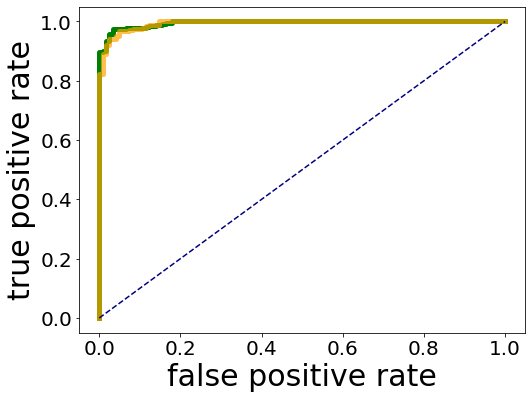

In [53]:
# roc curve all together 


fpr, tpr, thresholds = get_roc_curve(best_model, train_pool, plot=False)

roc = roc_auc_score(y_test, best_model.predict_proba(X_test)[: , 1])

# print(thresholds)
## calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# auc = roc_auc_score(y_test, probs)

fig, ax = plt.subplots(figsize = (8,6))
# morh + climate - green
plt.plot(fpr, tpr, color = 'green', linewidth=5, label = 'morphometry + climate (auc = %0.2f)' % roc)
# morph - orange
plt.plot(fpr2, tpr2, color = 'orange', linewidth=5, alpha = 0.7, label = 'morphometry (auc = %0.2f)' % roc2)

plt.plot([0, 1], [0, 1], color="navy", linestyle= "--", label = '1-1 line (auc = 0.5)')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('false positive rate', fontsize=30)
plt.ylabel('true positive rate',fontsize=30)
# plt.legend(fontsize=20)

# plt.savefig('figs_talk/both_roc_poster.pdf')




## prediction and shap values

In [32]:
probs2 = best_model2.predict_proba(X2)


In [33]:
feature_import2 = best_model2.get_feature_importance(prettified=True)
feature_import2.head()

,Feature Id,Importances
0,area_m,11.932726
1,mean_slope,11.570669
2,M,10.083655
3,region,7.182448
4,perimeter,6.657515


In [34]:
shap_values_X2   = best_model2.get_feature_importance(data_pool2, type='ShapValues')
shap_values_test2 = best_model2.get_feature_importance(test_pool2, type='ShapValues')

shap_values_test2 = shap_values_test2[:,:-1]

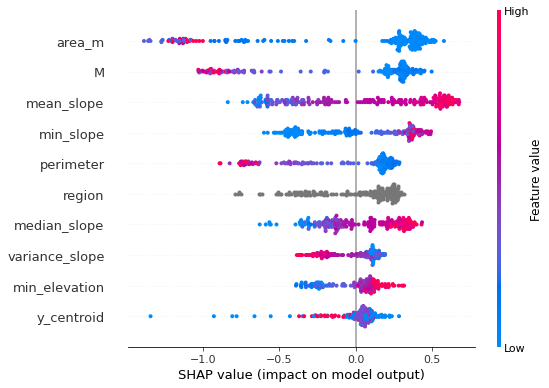

In [39]:
explainer2= shap.TreeExplainer(best_model2)

shap_valuesTE2 = explainer2.shap_values(X_test2)
shap.summary_plot(shap_valuesTE2, X_test2, max_display=10,show=False)

# plt.savefig('figs_talk/morph_shap_testdata_first10.pdf')

In [85]:
shap_values = explainer.shap_values(X_test)

In [ ]:
# hyperparams matter but not that much for this toy-model exersise 

# ## hyperparameters tuning: 

# hyperparams = {'depth'         :[2,4,6,8,10],
#                'learning_rate' :[0.01,0.03,0.05,0.07,0.1],
#                'l2_leaf_reg'  : [0, 2, 1],
#                'iterations' : [28]
#                }


# # cv: None — Use the default three-fold cross-validation.
# # 
# Grid_CBC = GridSearchCV(estimator=best_model, param_grid = hyperparams, cv = 2, n_jobs=-1)

# # Grid_CBC.fit(X_train, y_train)

# Grid_CBC.fit(
#     X_train, y_train,
#     cat_features=cat_features,
#     eval_set=(X_test, y_test), 
# #     logging_level='Verbose',  # you can uncomment this for text output
#     plot=True
# )


# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)|